In [20]:
import numpy as np
import pennylane as qml
import random
import torch
import scipy.stats
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [21]:
def QuantumStateDataset(num_samples=70):
    data = []
    labels = []

    for _ in range(num_samples):
        matrix1, matrix2, matrix3= generate_random_special_unitary(2), generate_random_special_unitary(2), generate_random_special_unitary(2)
       
        combined_matrix_in2 = np.kron(matrix1, matrix2)
        combined_matrix = np.kron(combined_matrix_in2, matrix3)
        
            
        # Define possible initial states
        in_state = np.array([1, 0, 0, 0, 0, 0, 0, 1], dtype=np.float64) / np.sqrt(np.array(2.0))     #GHZ state
        # in_state = np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=np.float64)                            #Fully separable state
        # in_state = np.array([1, 0, 0, 0, 0, 0, 1, 0], dtype=np.float64) / np.sqrt(np.array(2.0))   #AB-C state
        # in_state = np.array([1, 0, 0, 1, 0, 0, 0, 0], dtype=np.float64) / np.sqrt(np.array(2.0))   #A-BC state
        # in_state = np.array([1, 0, 0, 0, 0, 1, 0, 0], dtype=np.float64) / np.sqrt(np.array(2.0))   #AC-B state
        # in_state = np.array([0, 1, 1, 0, 1, 0, 0, 0], dtype=np.float64) / np.sqrt(np.array(3.0))   #W state
    
        random_complex = np.random.randn(8) + 1j * np.random.randn(8)
        norm_random_complex = np.linalg.norm(random_complex)
        random_complex_state = random_complex/ norm_random_complex

        initial_state, label = random.choice([(in_state, 1), (random_complex_state, -1)])
        resulting_state = np.dot(combined_matrix, initial_state)
        norm = np.linalg.norm(resulting_state)
        normalized_resulting_state = resulting_state / norm

        data.append(normalized_resulting_state)
        labels.append(label)
    return data, labels

def generate_random_special_unitary(n):
    """Generate a random n x n special unitary matrix (Haar distributed)."""
    matrix =  scipy.stats.unitary_group.rvs(n)
    det = np.linalg.det(matrix)
    matrix /= det**(1/n)
    return matrix

class QuantumStateTorchDataset(Dataset):
    def __init__(self, states, labels):
        self.states = torch.tensor(states, dtype=torch.complex64)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

class RealOutputWrapper(torch.nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer

    def forward(self, x):
        q_out = self.qlayer(x)
        return q_out.real 

def accuracy(X, Y):
    predictions = torch.sign(X)
    acc = ((predictions+Y)**2)/4
    return acc

In [22]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

def variational_circuit(weights, inputs):
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))]

@qml.qnode(dev)
def quantum_model(weights, inputs):
    return variational_circuit(weights, inputs)

In [23]:
X_train_o, y_train_o = QuantumStateDataset(num_samples=5500)
X_test_o, y_test_o = QuantumStateDataset(num_samples=5500)

X_train= np.array(X_train_o)
y_train = np.array(y_train_o)
y_train = y_train.reshape(-1,1)
X_test= np.array(X_test_o)
y_test = np.array(y_test_o)
y_test = y_test.reshape(-1,1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print(X_train, X_test, y_train, y_test)

(5500, 8) (5500, 8) (5500, 1) (5500, 1)


In [24]:
num_layers = 4
lr=0.001
weight_shapes = {"weights": (num_layers, n_qubits, 3)}

num_epochs = 300
batch_size = 10
batches = (X_train.shape[0]) // batch_size
batches_test = (X_test.shape[0]) // batch_size

train_dataset = QuantumStateTorchDataset(X_train, y_train)
test_dataset = QuantumStateTorchDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [25]:
qlayer = qml.qnn.TorchLayer(quantum_model, weight_shapes)
clayer1 = torch.nn.Linear(3, 350)
clayer2 = torch.nn.Linear(350, 100)
clayer3 = torch.nn.Linear(100, 1)
tanh = torch.nn.Tanh()
model = torch.nn.Sequential(RealOutputWrapper(qlayer), clayer1, tanh, clayer2, tanh, clayer3, tanh)
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()

In [26]:
epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []
train_auc_list=[]
test_auc_list=[]

In [27]:
for epoch in range(num_epochs):

    running_loss = 0

    for x, y in train_loader:
        opt.zero_grad()
        #print(model(x).shape)
        #print(y.shape)
        loss_evaluated = loss(model(x), y)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    loss_list.append(avg_loss.item())
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    if avg_loss <= 0.1:
        print(f"Stopping early at epoch {epoch + 1} (avg_loss ≤ 0.1)")
        break

Average loss over epoch 1: 1.0229
Average loss over epoch 2: 1.0063
Average loss over epoch 3: 1.0040
Average loss over epoch 4: 1.0000
Average loss over epoch 5: 0.9906
Average loss over epoch 6: 0.9704
Average loss over epoch 7: 0.9440
Average loss over epoch 8: 0.9176
Average loss over epoch 9: 0.8879
Average loss over epoch 10: 0.8592
Average loss over epoch 11: 0.7928
Average loss over epoch 12: 0.4600
Average loss over epoch 13: 0.2113
Average loss over epoch 14: 0.1637
Average loss over epoch 15: 0.1420
Average loss over epoch 16: 0.1243
Average loss over epoch 17: 0.1125
Average loss over epoch 18: 0.1062
Average loss over epoch 19: 0.0968
Stopping early at epoch 19 (avg_loss ≤ 0.1)


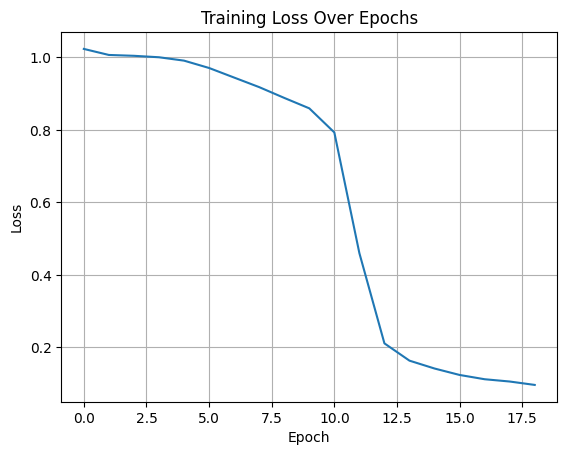

In [28]:
plt.plot(loss_list)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [29]:
running_loss=0
for x, y in train_loader:
        loss_evaluated = loss(model(x), y)
        running_loss += loss_evaluated
avg_loss = running_loss / batches
print("Average loss for training dataset",avg_loss)

running_acc=0
for x, y in train_loader:
        acc_evaluated = accuracy(model(x), y)
        running_acc += torch.mean(acc_evaluated) 
avg_acc = running_acc / batches
print("Accuracy for training dataset", avg_acc) 

Average loss for training dataset tensor(0.0721, grad_fn=<DivBackward0>)
Accuracy for training dataset tensor(0.9820, grad_fn=<DivBackward0>)


In [30]:
running_loss_test=0
for x, y in test_loader:
        loss_evaluated_test = loss(model(x), y)
        running_loss_test += loss_evaluated_test
avg_loss_test = running_loss_test / batches_test
print("Average loss for test dataset", avg_loss_test)

running_acc_test=0
for x, y in test_loader:
        acc_evaluated_test = accuracy(model(x), y)
        running_acc_test += torch.mean(acc_evaluated_test)
avg_acc_test = running_acc_test / batches_test
print("Accuracy for test dataset",avg_acc_test)

Average loss for test dataset tensor(0.0727, grad_fn=<DivBackward0>)
Accuracy for test dataset tensor(0.9816, grad_fn=<DivBackward0>)
